In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from importlib import reload
import warnings
import ot
from collections import Counter
from itertools import combinations

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

In [2]:
resolution = 1000000
chrom = "chr7"

dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/"

file_list = sorted(glob.glob(f"{dpath}*_{resolution}_{chrom}*"))
print(file_list)

population_path = file_list[0]
singlecell_path = file_list[1]

print()

print(f"{population_path=}")
print(f"{singlecell_path=}")

['/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/population_mESC_1000000_chr7.h5ad', '/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/singlecell_mESC_1000000_chr7.h5ad']

population_path='/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/population_mESC_1000000_chr7.h5ad'
singlecell_path='/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/singlecell_mESC_1000000_chr7.h5ad'


# Load population data

In [3]:
start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
adata

Time taken to read the file: 3.29 seconds
Memory usage: current 0.82 GB, difference +0.82 GB


AnnData object with n_obs × n_vars = 142 × 85534
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

# Load single-cell data

In [4]:
start_time = time.time()  # Record the start time
bdata = sc.read_h5ad(singlecell_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
bdata

Time taken to read the file: 31.85 seconds
Memory usage: current 1.81 GB, difference +0.98 GB


AnnData object with n_obs × n_vars = 142 × 851428
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

# QC

In [5]:
def find_outliers_iqr(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

adata.obs['degree_outlier'] = find_outliers_iqr(adata.obs['chrom_degree'])
adata.obs[['chrom_bin', 'chrom_degree', 'degree_outlier']].sort_values(by='chrom_degree', ascending=False).head()

,chrom_bin,chrom_degree,degree_outlier
bin_name,,,
chr7:7,7,2476,True
chr7:8,8,2416,True
chr7:9,9,2147,False
chr7:40,40,2021,False
chr7:15,15,1942,False


# Clique-Expansion

In [6]:
matrix.expand_and_normalize_anndata(adata)
print()
matrix.expand_and_normalize_anndata(bdata)

Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.

Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.


A.shape=(137, 137) B.shape=(137, 137)


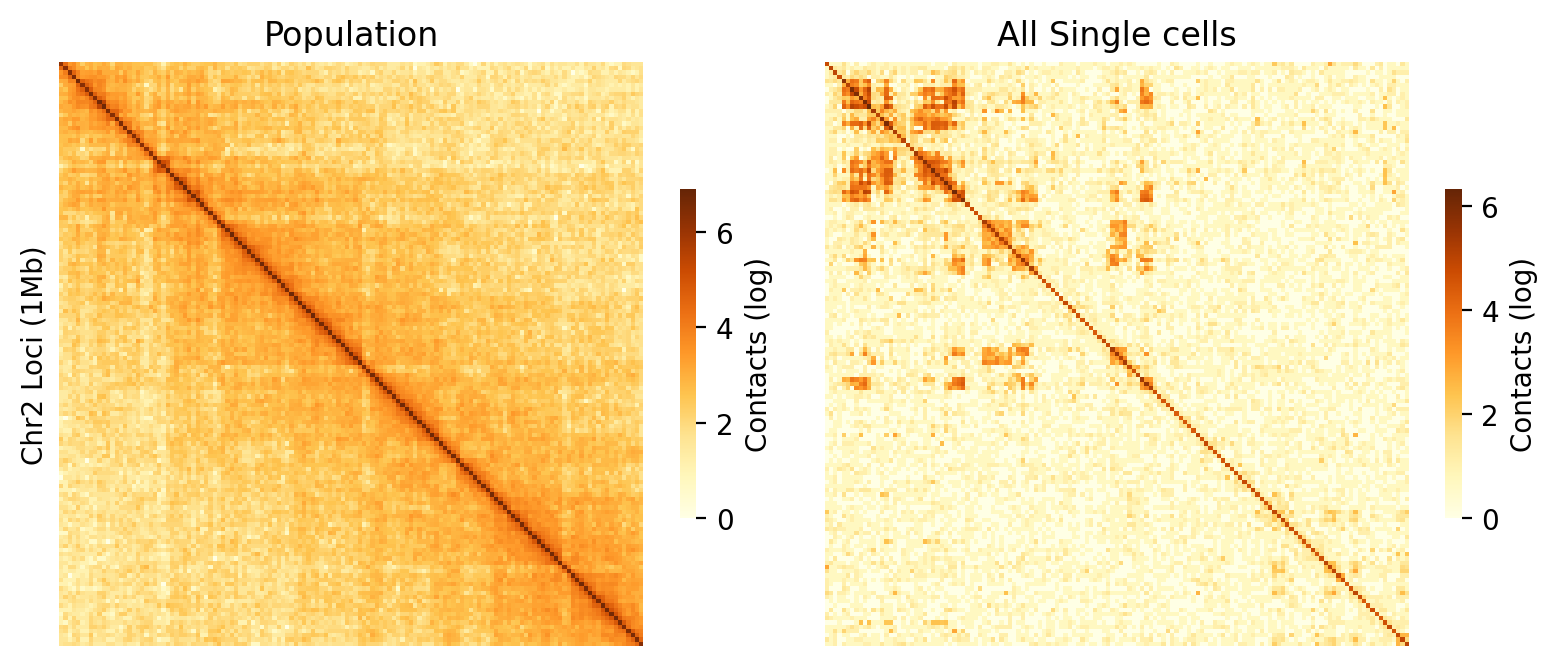

In [7]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

cmap = 'YlOrBr'
layer = 'A'
log = True
A = adata.obsm[layer]
B = bdata.obsm[layer]

# remove outliers
outliers = adata.obs[adata.obs['degree_outlier']].index.to_list()

A = A.drop(outliers, axis=0).drop(outliers, axis=1)
B = B.drop(outliers, axis=0).drop(outliers, axis=1)

cbar_label = f"Contacts"

if log:
    A = np.log1p(A)
    B = np.log1p(B)
    cbar_label = f"Contacts (log)"

print(f"{A.shape=} {B.shape=}")

fig, axs = plt.subplots(1, 2, sharey=True)
axs = axs.ravel()

sns.heatmap(
    A,
    square=True,
    cmap=cmap,
    cbar_kws={'shrink' : 0.35, 'label' : cbar_label},
    ax=axs[0],
)

axs[0].set_yticks([])
axs[0].set_xticks([])
axs[0].set_title(f"Population")
axs[0].set_xlabel("")
axs[0].set_ylabel(f"Chr2 Loci (1Mb)")

sns.heatmap(
    B,
    square=True,
    cmap=cmap,
    cbar_kws={'shrink' : 0.35, 'label' : cbar_label},
    ax=axs[1],
)

axs[1].set_yticks([])
axs[1].set_xticks([])
axs[1].set_title(f"All Single cells")
axs[1].set_xlabel("")
axs[1].set_ylabel(f"")

plt.tight_layout()

In [8]:
# break

In [9]:
print(f"{np.max(A)=}")
print(f"{np.min(A)=}")
print(f"{np.max(B)=}")
print(f"{np.min(B)=}")

np.max(A)=6.888572459565363
np.min(A)=0.0
np.max(B)=6.315358001522335
np.min(B)=0.0


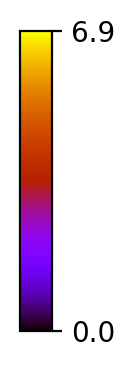

In [10]:
plt2.make_colorbar(
    cmap='gnuplot',
    tick_labels=[0.0, f"{np.max(A):.2}"]
)

# build consecutive single-cell profiles

In [11]:
# layer = 'A'
# cell_nums = [1, 5, 50, 150, 200, 350]

# # remove outliers
# outliers = adata.obs[adata.obs['degree_outlier']].index.to_list()
# cell_ids = list(bdata.var['basename'].unique())

# fig, axs = plt.subplots(2, 3)
# axs = axs.ravel()

# for i, n in enumerate(cell_nums):
#     print(f"Working {n} cells...")
#     cell_idx = cell_ids[:n]

#     X = bdata[:, bdata.var['basename'].isin(cell_idx)].copy()
#     A = matrix.clique_expand_incidence(X.to_df(), zero_diag=False)
#     A = A.drop(outliers, axis=0).drop(outliers, axis=1)

#     sns.heatmap(
#         np.where(A > 0, 1, 0),
#         square=True,
#         cmap=['w', 'k'],
#         cbar=False,
#         ax=axs[i]
#     )
    
#     axs[i].set_title(f"{n} Cells")
#     axs[i].set_yticks([])
#     axs[i].set_xticks([])

# plt.tight_layout()

In [12]:
# layer = 'A_kr'
# A = adata.obsm[layer]
# B = bdata.obsm[layer]

# # remove outliers
# outliers = adata.obs[adata.obs['degree_outlier']].index.to_list()

# A = A.drop(outliers, axis=0).drop(outliers, axis=1)
# B = B.drop(outliers, axis=0).drop(outliers, axis=1)

# X = A - B

# sns.heatmap(
#     X,
#     square=True,
#     cmap='bwr',
#     cbar_kws={'shrink' : 0.45, 'ticks' : [np.min(X), np.max(X)], 'spacing' : 'proportional'},
# )

# # Get the colorbar object
# cbar = plt.gca().collections[0].colorbar 

# # Set the tick labels
# cbar.set_ticklabels(["Enriched in Sc.", "Enriched in Pop.", ]) 

# plt.yticks([])
# plt.xticks([])

# plt.ylabel("")
# plt.xlabel("")

# Sc-Population contact alignment

Sparsity of A: 0.0009
Sparsity of B: 0.3282


Text(0.5, 51.44444444444443, '')

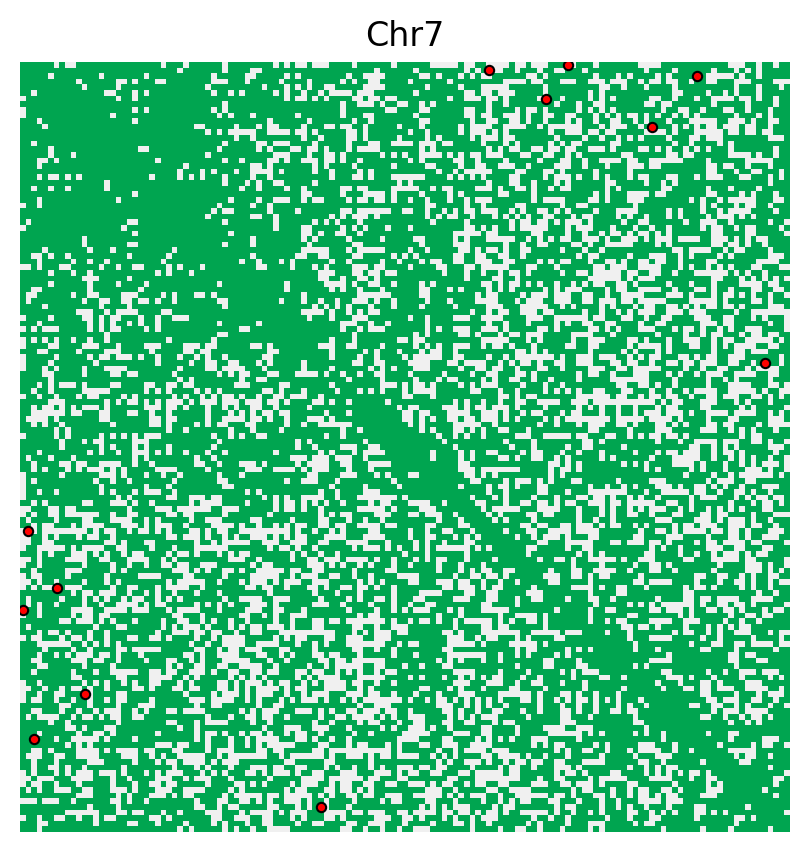

In [13]:
layer = 'A'
A = adata.obsm[layer]
B = bdata.obsm[layer]

# remove outliers
outliers = adata.obs[adata.obs['degree_outlier']].index.to_list()

A = A.drop(outliers, axis=0).drop(outliers, axis=1)
B = B.drop(outliers, axis=0).drop(outliers, axis=1)

def sparsity(matrix):
  num_zeros = np.count_nonzero(matrix == 0)
  total_elements = matrix.size
  return num_zeros / total_elements

A = np.where(A > 0, 1, 0)
B = np.where(B > 0, 1, 0)

# Calculate sparsity for A and B
sparsity_A = sparsity(A)
sparsity_B = sparsity(B)

print(f"Sparsity of A: {sparsity_A:.4f}")
print(f"Sparsity of B: {sparsity_B:.4f}")

X = A - B


sns.heatmap(
    X,
    square=True,
    cbar=False,
    cmap=['r', '#00A550', '#F0F0F0'],
)

# Get the coordinates of the red points
red_points = np.where(X == -1)
row_coords, col_coords = red_points

# Plot larger red points on top of the heatmap
plt.scatter(
    col_coords + 0.5, 
    row_coords + 0.5, 
    s=45, 
    c='red', 
    marker='.',
    ec='k',
    lw=0.75,
) 

plt.yticks([])
plt.xticks([])
plt.title(f"{chrom.title()}")

plt.ylabel("")
plt.xlabel("")

In [14]:
# break

In [15]:
# sample_size = 500

# a_color = 'r'
# b_color = 'b'

# color_map = {}

# H_a = adata.to_df()
# H_a = H_a.T.sample(sample_size).T

# H_b = bdata.to_df()
# H_b = H_b.T.sample(sample_size).T

# for read in H_a.columns:
#     color_map[read] = a_color

# for read in H_b.columns:
#     color_map[read] = b_color


# print(f"{H_a.shape=}")
# print(f"{H_b.shape=}")

# H = pd.concat([H_a, H_b], axis=1, ignore_index=False)
# H = H.drop(outliers, axis=0, errors='ignore')
# H = H.reset_index(drop=True)
# H = ut.sort_by_lowest_index(H)

# node_colors = H.columns.map(color_map).to_list()

# node_params = {
#     's' : 5,
#     'ec' : 'k',
#     'lw' : 0.5,
#     'marker' : "o",
#     'zorder' : 2,
# }

# line_params = {
#     'lw' : 0.25,
#     'alpha' : 0.5,
#     'zorder' : 1,
# }

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 8, 4


# plt2.plot_incidence(
#     H, node_color=node_colors,
#     node_params=node_params,
#     line_params=line_params,
# )

# # plt.title(f"Chromosome 2")
# plt.ylabel("Chromosome 2 Loci")
# plt.xlabel("Read Index")
# sns.despine()

H_a.shape=(142, 1000)
H_b.shape=(142, 1000)


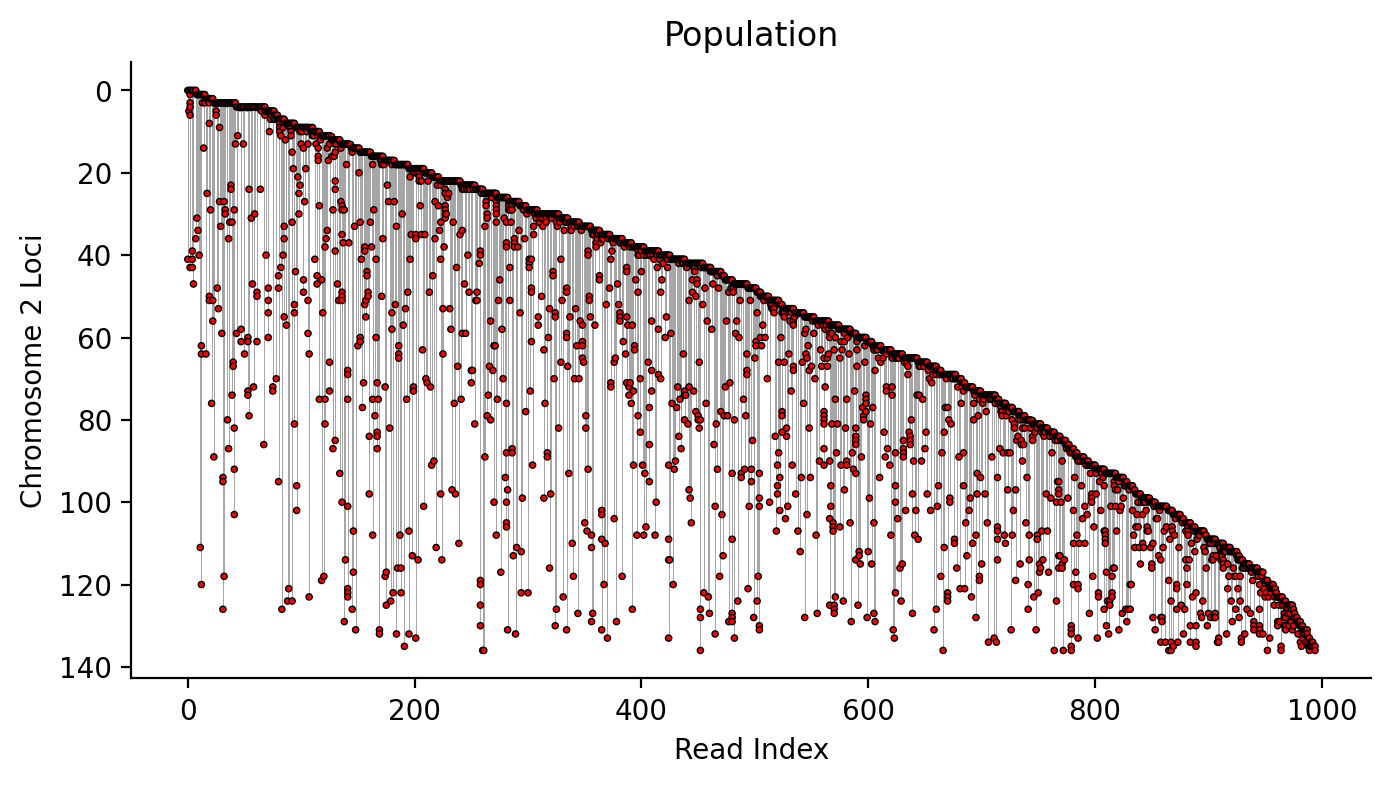

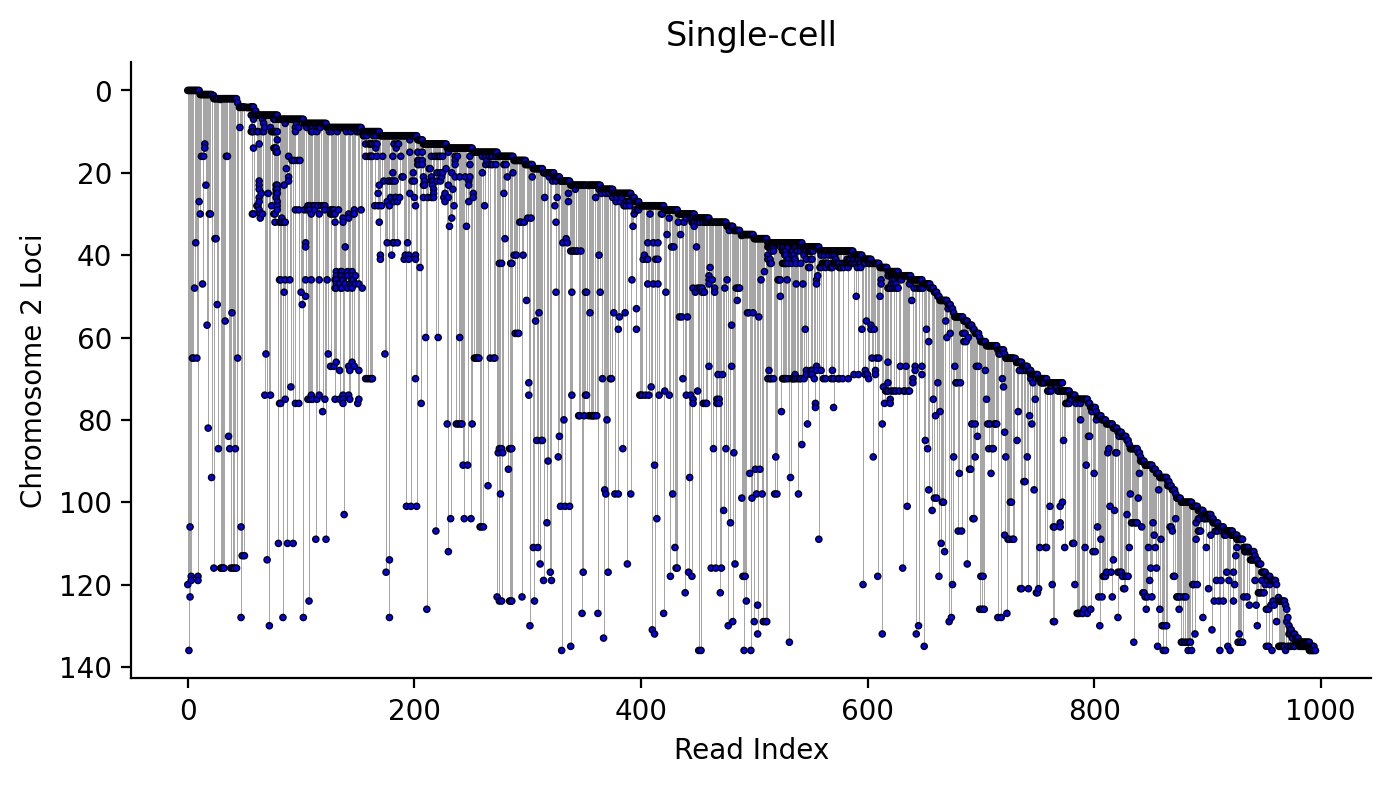

In [16]:
sample_size = 1000

a_color = 'r'
b_color = 'b'

color_map = {}

H_a = adata.to_df()
H_a = H_a.T.sample(sample_size).T

H_b = bdata.to_df()
H_b = H_b.T.sample(sample_size).T

for read in H_a.columns:
    color_map[read] = a_color

for read in H_b.columns:
    color_map[read] = b_color


print(f"{H_a.shape=}")
print(f"{H_b.shape=}")

H = pd.concat([H_a, H_b], axis=1, ignore_index=False)
H = H.drop(outliers, axis=0, errors='ignore')
H = H.reset_index(drop=True)
H = ut.sort_by_lowest_index(H)


H_a = H_a.drop(outliers, axis=0, errors='ignore')
H_a = H_a.reset_index(drop=True)
H_a = ut.sort_by_lowest_index(H_a)


node_params = {
    's' : 5,
    'ec' : 'k',
    'lw' : 0.5,
    'marker' : "o",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.25,
    'alpha' : 0.5,
    'zorder' : 1,
}

node_colors = H.columns.map(color_map).to_list()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4


plt2.plot_incidence(
    H_a, node_color='r',
    node_params=node_params,
    line_params=line_params,
)

plt.title("Population")
plt.ylabel("Chromosome 2 Loci")
plt.xlabel("Read Index")
sns.despine()
plt.show()

H_b = H_b.drop(outliers, axis=0, errors='ignore')
H_b = H_b.reset_index(drop=True)
H_b = ut.sort_by_lowest_index(H_b)

plt2.plot_incidence(
    H_b, node_color='b',
    node_params=node_params,
    line_params=line_params,
)

plt.title("Single-cell")
plt.ylabel("Chromosome 2 Loci")
plt.xlabel("Read Index")
sns.despine()

plt.show()

In [17]:
# break

# Compute order and degree statistics

H_a.shape=(142, 33195)
H_b.shape=(142, 8743)


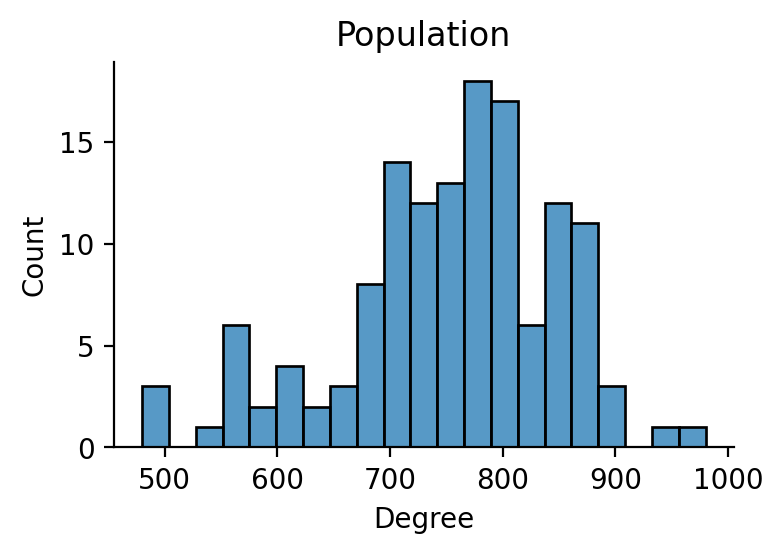

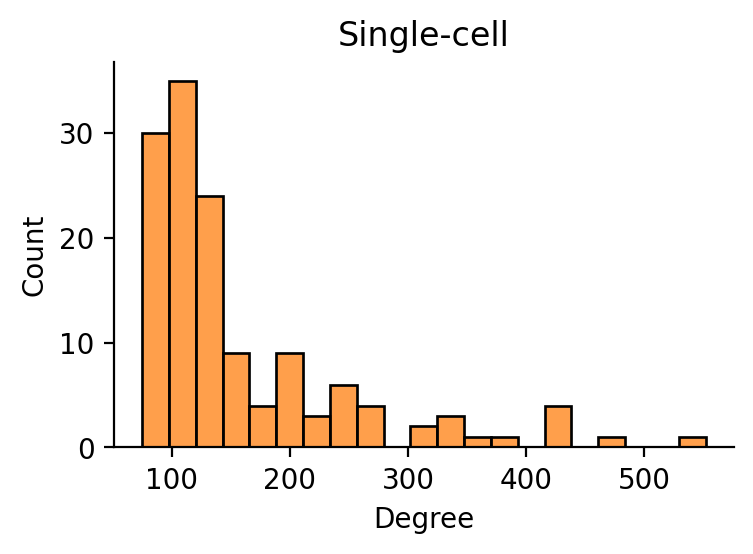

In [18]:
H_a = adata.to_df()
H_a = H_a.T.drop_duplicates().T
print(f"{H_a.shape=}")

a_degree = H_a.sum(axis=1)
a_degree = a_degree.drop(outliers, axis=0)

H_b = bdata.to_df()
H_b = H_b.T.drop_duplicates().T
print(f"{H_b.shape=}")

b_degree = H_b.sum(axis=1)
b_degree = b_degree.drop(outliers, axis=0)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5

sns.histplot(
    x=a_degree,
    bins=21,
)

plt.title("Population")
plt.xlabel("Degree")
plt.ylabel("Count")
sns.despine()
plt.show()

sns.histplot(
    x=b_degree,
    bins=21,
    color="C1",
)

plt.title("Single-cell")
plt.xlabel("Degree")
plt.ylabel("Count")
sns.despine()
plt.show()

H_a.shape=(142, 33195)


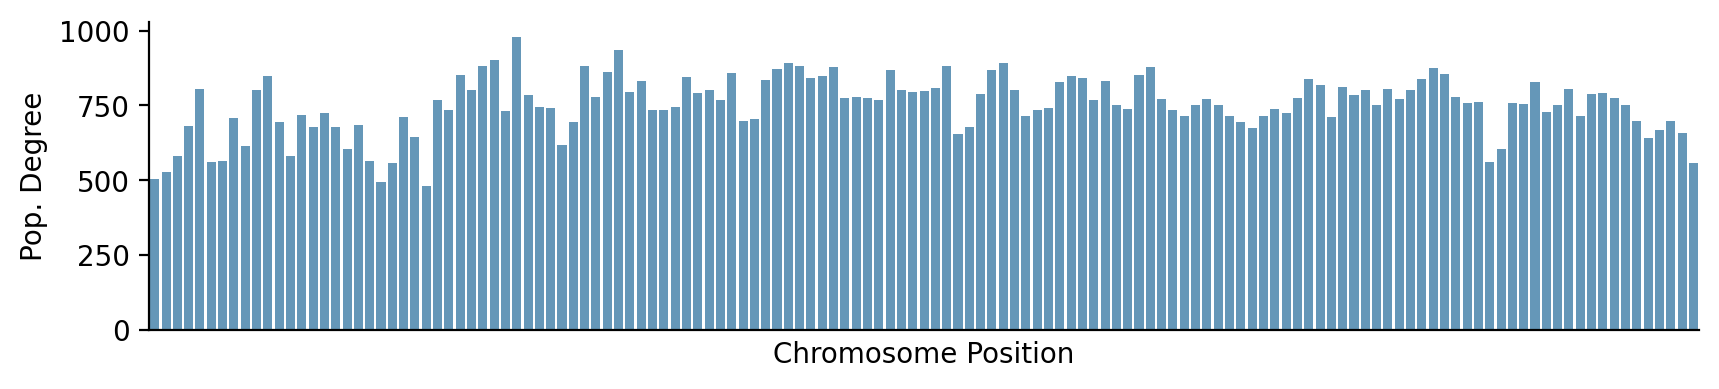

In [19]:
H_a = adata.to_df()
H_a = H_a.T.drop_duplicates().T
print(f"{H_a.shape=}")

a_degree = H_a.sum(axis=1)
a_degree = a_degree.drop(outliers, axis=0)
a_degree = a_degree.reset_index(drop=False)

a_degree.head()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 2

sns.barplot(
    data=a_degree,
    x='bin_name',
    y=0,
    alpha=0.75,
)

plt.xticks([])
plt.xlabel("Chromosome Position")
plt.ylabel("Pop. Degree")
sns.despine()

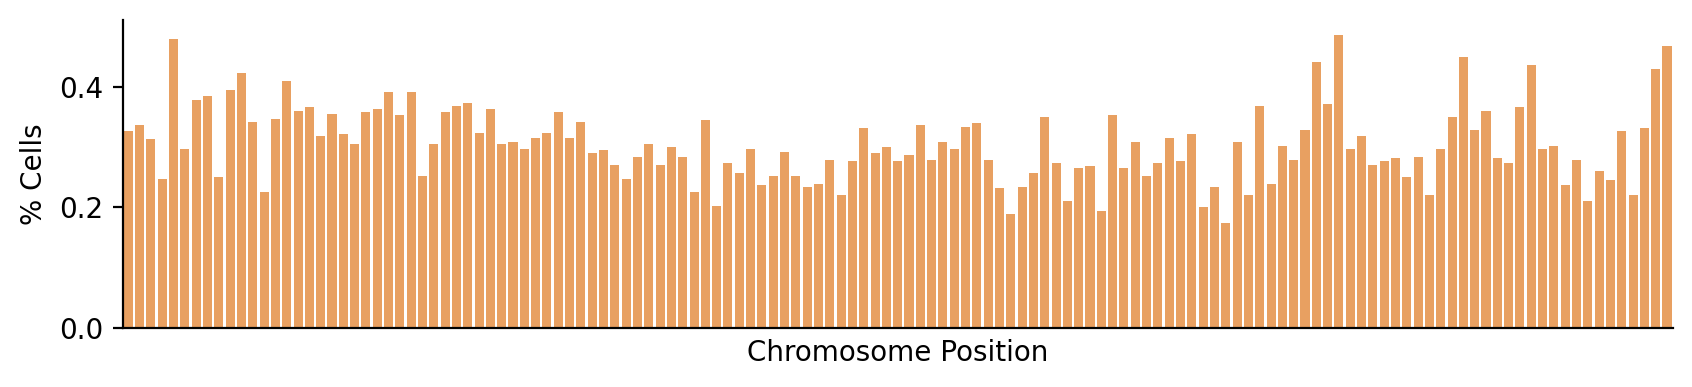

In [20]:
H_b = bdata.to_df()
H_b.columns = bdata.var['basename'].values

def get_nonzero_cols(row):
  """Returns a list of column names with nonzero values for a given row."""
  return len(set([H_b.columns[i] for i in np.where(row != 0)[0]]))

cell_coverage = pd.DataFrame(H_b.apply(get_nonzero_cols, axis=1), columns=['n_cells'])
cell_coverage = cell_coverage.drop(outliers, axis=0)
cell_coverage['percent_cells'] = cell_coverage['n_cells'] / 380
cell_coverage = cell_coverage.reset_index(drop=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 2

sns.barplot(
    data=cell_coverage,
    x='bin_name',
    y='percent_cells',
    alpha=0.75,
    color="C1",
)

plt.xticks([])
plt.xlabel("Chromosome Position")
plt.ylabel("% Cells")
sns.despine()

In [21]:
# break

# Compute edge overlap

In [22]:
print(f"{adata.X.shape=}")
print(f"{bdata.X.shape=}")

adata.X.shape=(142, 85534)
bdata.X.shape=(142, 851428)


In [23]:
# Timing for dataset 'a'
start_time_a = time.time()

print(f"{adata.X.shape=}")

a_df = adata.to_df().T
print(f"{a_df.shape=}")
a_df = a_df.drop_duplicates()
print(f"{a_df.shape=}")

end_time_a = time.time()
print(f"Execution time for dataset 'a': {end_time_a - start_time_a:.2f} seconds\n")

# Timing for dataset 'b'
start_time_b = time.time()

print(f"{bdata.X.shape=}")

b_df = bdata.to_df().T
print(f"{b_df.shape=}")
b_df = b_df.drop_duplicates()
print(f"{b_df.shape=}")

end_time_b = time.time()
print(f"Execution time for dataset 'b': {end_time_b - start_time_b:.2f} seconds")

# Total execution time
total_time = end_time_a - start_time_a + end_time_b - start_time_b
print(f"Total execution time: {total_time:.2f} seconds")

adata.X.shape=(142, 85534)
a_df.shape=(85534, 142)
a_df.shape=(33195, 142)
Execution time for dataset 'a': 0.56 seconds

bdata.X.shape=(142, 851428)
b_df.shape=(851428, 142)
b_df.shape=(8743, 142)
Execution time for dataset 'b': 5.19 seconds
Total execution time: 5.75 seconds


In [24]:
def zip_loci(read):
    nodes_in_hyperedge = sorted(np.nonzero(read)[0])
    ".".join(map(str, nodes_in_hyperedge))
    return ".".join(map(str, nodes_in_hyperedge))

a_hyperdges = pd.DataFrame(a_df.apply(zip_loci, axis=1), columns=['loci'])
a_hyperdges = a_hyperdges.sort_values(by='loci').reset_index(drop=False)

b_hyperdges = pd.DataFrame(b_df.apply(zip_loci, axis=1), columns=['loci'])
b_hyperdges = b_hyperdges.sort_values(by='loci').reset_index(drop=False)

print(f"{a_hyperdges.shape=}")
print(f"{b_hyperdges.shape=}")

a_hyperdges.shape=(33195, 2)
b_hyperdges.shape=(8743, 2)


In [25]:
def compare_loci(df1, df2):
  """
  Compares the loci in two pandas DataFrames.

  Args:
    df1: The first pandas DataFrame with a 'loci' column.
    df2: The second pandas DataFrame with a 'loci' column.

  Returns:
    A tuple containing three sets and three percentages:
      - common_loci: The set of loci present in both DataFrames.
      - df1_unique_loci: The set of loci unique to df1.
      - df2_unique_loci: The set of loci unique to df2.
      - perc_df1_in_df2: Percentage of df1 loci found in df2.
      - perc_df2_in_df1: Percentage of df2 loci found in df1.
      - perc_common: Percentage of common loci relative to both DataFrames.
  """

  loci1 = set(df1['loci'])
  loci2 = set(df2['loci'])

  common_loci = loci1.intersection(loci2)
  df1_unique_loci = loci1.difference(loci2)
  df2_unique_loci = loci2.difference(loci1)

  perc_df1_in_df2 = len(common_loci) / len(loci1) * 100 if loci1 else 0
  perc_df2_in_df1 = len(common_loci) / len(loci2) * 100 if loci2 else 0
  perc_common = len(common_loci) / (len(loci1) + len(loci2) - len(common_loci)) * 100 if (loci1 or loci2) else 0

  return (
      common_loci,
      df1_unique_loci,
      df2_unique_loci,
      perc_df1_in_df2,
      perc_df2_in_df1,
      perc_common,
  )

(
    common_loci,
    df1_unique_loci,
    df2_unique_loci,
    perc_df1_in_df2,
    perc_df2_in_df1,
    perc_common,
) = compare_loci(a_hyperdges, b_hyperdges)

print("common loci:", len(common_loci))
print("unique loci in df1:", len(df1_unique_loci))
print("unique loci in df2:", len(df2_unique_loci))
print(f"Percentage of df1 loci found in df2: {perc_df1_in_df2:.2f}%")
print(f"Percentage of df2 loci found in df1: {perc_df2_in_df1:.2f}%")
print(f"Percentage of common loci relative to both DataFrames: {perc_common:.2f}%")

common loci: 5829
unique loci in df1: 27366
unique loci in df2: 2914
Percentage of df1 loci found in df2: 17.56%
Percentage of df2 loci found in df1: 66.67%
Percentage of common loci relative to both DataFrames: 16.14%


In [26]:
mismatch = b_hyperdges[b_hyperdges['loci'].isin(df2_unique_loci)]
len(mismatch)
mismatch.head()

,read_name,loci
2,4abc313b-3957-427d-923a-50d034960e03,0.102
5,3749fdfd-7e29-4962-a384-d31b5425ffb1,0.106.110.114
7,5e99ee30-fccb-4ddb-8668-b08ff8fa9672_1,0.109
9,8ea2fddd-3c5e-4908-9056-5fd1af6fec9f,0.110.114
10,be8d9ac7-7025-49c3-b086-d5046eb2aa6e,0.110.123


In [27]:
missing_reads = bdata.var[bdata.var.index.isin(mismatch['read_name'].to_list())].copy()
missing_reads = missing_reads.reset_index(drop=False)
print(f"{missing_reads.shape=}")
print(f"{missing_reads['basename'].nunique()=}")
missing_reads.head()

missing_reads.shape=(2914, 12)
missing_reads['basename'].nunique()=218


,read_name,read_index,basename,mean_mapq,median_mapq,n_chromosomes,order,n_bins,read_length_bp,genes,n_genes,chrom_order
0,e6f2abec-2d2e-4fc1-ac1f-93b8d7278a0c,115,o3b43,46.846154,60.0,2,13,6,4918,Adamtsl3;Bsph2;Nlrp5-ps;Stk32b,4,5
1,74082a84-499b-4481-9996-4b1d274456e4,1167,o3b43,57.440000,60.0,3,25,7,8552,Peli1;Nell1;Nav2,3,4
2,ec5db31e-c0ae-44c5-91e0-bc40f486a37f,3050,o1b59,52.500000,60.0,2,8,3,4518,Alpk3;Zfp592,2,2
3,6ef34db6-106a-4e03-a149-3548caf5cecd,3061,o3b43,28.625000,24.0,5,8,7,6271,Apol11a;Gabrp;Fgfr2,3,2
4,3bf39bd8-03a4-45bd-8c4a-49fad2b39d81,6118,o3b50,54.216216,60.0,7,37,18,11467,Rras2;Gm45307;Galntl6;Gm9967;Gpt2;Nrp1;Raver2;...,8,4


In [28]:
missing_reads['median_mapq'].mean()

43.490048043925874

# most common hyperedges

In [29]:
# Timing for dataset 'a'
start_time_a = time.time()

print(f"{adata.X.shape=}")

a_df = adata.to_df().T
print(f"{a_df.shape=}")

end_time_a = time.time()
print(f"Execution time for dataset 'a': {end_time_a - start_time_a:.2f} seconds\n")

# Timing for dataset 'b'
start_time_b = time.time()

print(f"{bdata.X.shape=}")

b_df = bdata.to_df().T
print(f"{b_df.shape=}")

end_time_b = time.time()
print(f"Execution time for dataset 'b': {end_time_b - start_time_b:.2f} seconds")

# Total execution time
total_time = end_time_a - start_time_a + end_time_b - start_time_b
print(f"Total execution time: {total_time:.2f} seconds")

print()

a_hyperdges = pd.DataFrame(a_df.apply(zip_loci, axis=1), columns=['loci'])
a_hyperdges = a_hyperdges.sort_values(by='loci').reset_index(drop=False)

b_hyperdges = pd.DataFrame(b_df.apply(zip_loci, axis=1), columns=['loci'])
b_hyperdges = b_hyperdges.sort_values(by='loci').reset_index(drop=False)

print(f"{a_hyperdges.shape=}")
print(f"{b_hyperdges.shape=}")

adata.X.shape=(142, 85534)
a_df.shape=(85534, 142)
Execution time for dataset 'a': 0.13 seconds

bdata.X.shape=(142, 851428)
b_df.shape=(851428, 142)
Execution time for dataset 'b': 0.68 seconds
Total execution time: 0.82 seconds

a_hyperdges.shape=(85534, 2)
b_hyperdges.shape=(851428, 2)


# check over-represented bins

In [30]:
adata.obs['degree_outlier'] = find_outliers_iqr(adata.obs['chrom_degree'])
adata.obs[['chrom_bin', 'chrom_degree', 'degree_outlier']].sort_values(by='chrom_degree', ascending=False).head()

,chrom_bin,chrom_degree,degree_outlier
bin_name,,,
chr7:7,7,2476,True
chr7:8,8,2416,True
chr7:9,9,2147,False
chr7:40,40,2021,False
chr7:15,15,1942,False


In [31]:
# MOst common 

In [32]:
a_common = pd.DataFrame(a_hyperdges['loci'].value_counts())
b_common = pd.DataFrame(b_hyperdges['loci'].value_counts())

common = pd.merge(
    a_common, b_common,
    how='inner',
    left_index=True,
    right_index=True,
).reset_index(drop=False)
common.columns = ['contact', 'population', 'singlecell']

common['order'] = common['contact'].apply(lambda x : x.count(".") + 1)
common = common[common['order'] > 2]

common['pop_rank'] = common['population'].rank(ascending=False)
common['sc_rank'] = common['singlecell'].rank(ascending=False)

print(f"{common.shape=}")
common.head(15)

common.shape=(323, 6)


,contact,population,singlecell,order,pop_rank,sc_rank
4,4.5.6,196,1914,3,1.0,6.0
138,28.29.30,48,58,3,2.0,82.0
165,17.18.19,31,268,3,3.0,38.0
171,32.33.34,29,1,3,4.0,276.0
179,35.36.37,27,3,3,5.5,192.0
181,5.6.7,27,4,3,5.5,174.5
212,10.11.12,23,27,3,7.0,109.5
235,130.131.132,21,5,3,8.0,164.5
242,27.28.29,20,1,3,9.0,276.0
255,139.140.141,19,1584,3,10.0,10.0


In [33]:
# break

In [34]:
n_top_contacts = 3

locus_list = common['contact'].head(n_top_contacts).values
locus_list = [x.split(".") for x in locus_list]
locus_list = list(set([item for sublist in locus_list for item in sublist]))
print("most common loci: ")
print(locus_list)

locus_list = [f"{chrom}:{x}" for x in locus_list]
genes = adata[locus_list, :].obs['genes'].values
genes = [x.split(";") for x in genes]
genes = [item for sublist in genes for item in sublist]
print(f"\n{len(genes)=}\n")
genes[:10]

most common loci: 
['17', '5', '4', '30', '28', '18', '6', '19', '29']

len(genes)=474



['Gm32846',
 'Gm32772',
 'Mill1',
 'Gm45150',
 'Gm44613',
 'Psg-ps1',
 'Gm5322',
 'Ceacam5',
 'Ceacam14',
 'Ceacam11']

In [35]:
# print(genes)

In [36]:
# database = 'Mouse_Gene_Atlas'
# edf = gget.enrichr(genes, database=database)

# pd.set_option('display.max_colwidth', 100)
# edf[['path_name', 'adj_p_val', 'overlapping_genes']].head()

In [37]:
obs = adata.obs.copy()

in_list = obs[obs.index.isin(locus_list)]
out_list = obs[~obs.index.isin(locus_list)]

print(f"{'In List Shape:':<20} {in_list.shape}")
print(f"{'Out List Shape:':<20} {out_list.shape}")
print("-" * 30)

columns = [
    'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
    'CTCF', 'H3K27ac', 'H3K27me3', 
]

data = []
for column in columns:
    data.append([column, in_list[column].mean(), out_list[column].mean()])

df = pd.DataFrame(data, columns=['Column', 'In List Mean', 'Out List Mean'])
print(df.to_markdown(index=False, numalign="left", stralign="left"))

In List Shape:       (9, 23)
Out List Shape:      (133, 23)
------------------------------
| Column    | In List Mean   | Out List Mean   |
|:----------|:---------------|:----------------|
| n_genes   | 52.6667        | 27.1729         |
| ATACSeq_1 | 0.682277       | 0.623753        |
| ATACSeq_2 | 0.64511        | 0.519091        |
| ATACSeq_3 | 0.67549        | 0.575445        |
| CTCF      | 1.07246        | 0.657183        |
| H3K27ac   | 1.28125        | 0.631018        |
| H3K27me3  | 0.575948       | 0.672031        |


In [38]:
order_threshold = 2
a_locus = adata[adata.obs.index.isin(locus_list), :].copy()
a_locus = a_locus[:, a_locus.X.sum(axis=0) > order_threshold].copy()

print(a_locus)
print()

b_locus = bdata[bdata.obs.index.isin(locus_list), :].copy()
b_locus = b_locus[:, b_locus.X.sum(axis=0) > order_threshold].copy()
b_locus


AnnData object with n_obs × n_vars = 9 × 130
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'
    obsm: 'A', 'A_kr', 'A_oe'



AnnData object with n_obs × n_vars = 9 × 7056
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'
    obsm: 'A', 'A_kr', 'A_oe'

# common gene interactions

In [39]:
def make_frame(common_elements):
  df = pd.DataFrame(common_elements, columns=['gene_name', 'contact_count'])
  df['gene_name'] = df['gene_name'].apply(lambda x: "-".join(x))
  df = df[df['gene_name'] != ""]
  df = df.set_index('gene_name')
  df['rank'] = df['contact_count'].rank(ascending=False)
  return df


def find_common_interactions(data, interaction_size):
  """
  Finds the most common interactions of a specified size from a list of gene interactions.

  Args:
    data: A list of strings, where each string is a semicolon-separated list of genes.
    interaction_size: The size of the interactions to find (e.g., 2 for pairwise interactions).

  Returns:
    A list of tuples, where each tuple contains an interaction (a tuple of genes) and its count.
  """

  all_interactions = []
  for item in data:
    genes = item.split(';')
    if len(genes) >= interaction_size:
      for interaction in combinations(genes, interaction_size):
        all_interactions.append(tuple(sorted(interaction)))

  interaction_counts = Counter(all_interactions)
  return interaction_counts.most_common()

order = 1
n_interactions = 2

a_common = find_common_interactions(adata.var['genes'].to_list(), order)
print("in population:")
print(a_common[:n_interactions])
print()

# remove amplification bias
b_genes = bdata.var[['basename', 'genes']].drop_duplicates().copy()
b_common = find_common_interactions(b_genes['genes'].to_list(), order)
print("in singel-cell:")
print(b_common[:n_interactions])
print()

a_df = make_frame(a_common)
b_df = make_frame(b_common)

df = pd.merge(
    a_df, b_df, how='inner',
    left_index=True,
    right_index=True,
    suffixes=['_pop', '_sc'],
).reset_index(drop=False)

df.head(10)

in population:
[(('',), 5811), (('Fgfr2',), 3524)]

in singel-cell:
[(('Fgfr2',), 1862), (('Obox1',), 1041)]



,gene_name,contact_count_pop,rank_pop,contact_count_sc,rank_sc
0,Fgfr2,3524,1.0,1862,1.0
1,Dlg2,2664,2.0,467,9.0
2,Chl1,1503,3.0,983,4.0
3,Nell1,1309,4.0,700,5.0
4,Agbl1,1297,5.0,1016,3.0
5,Nav2,1254,6.0,425,11.0
6,Tenm4,1247,7.0,204,49.0
7,Snhg14,1240,8.0,235,40.0
8,Ntrk3,983,9.0,368,15.0
9,Gabrg3,972,10.0,388,13.0


At quantile 0.995, count threshold is ~400


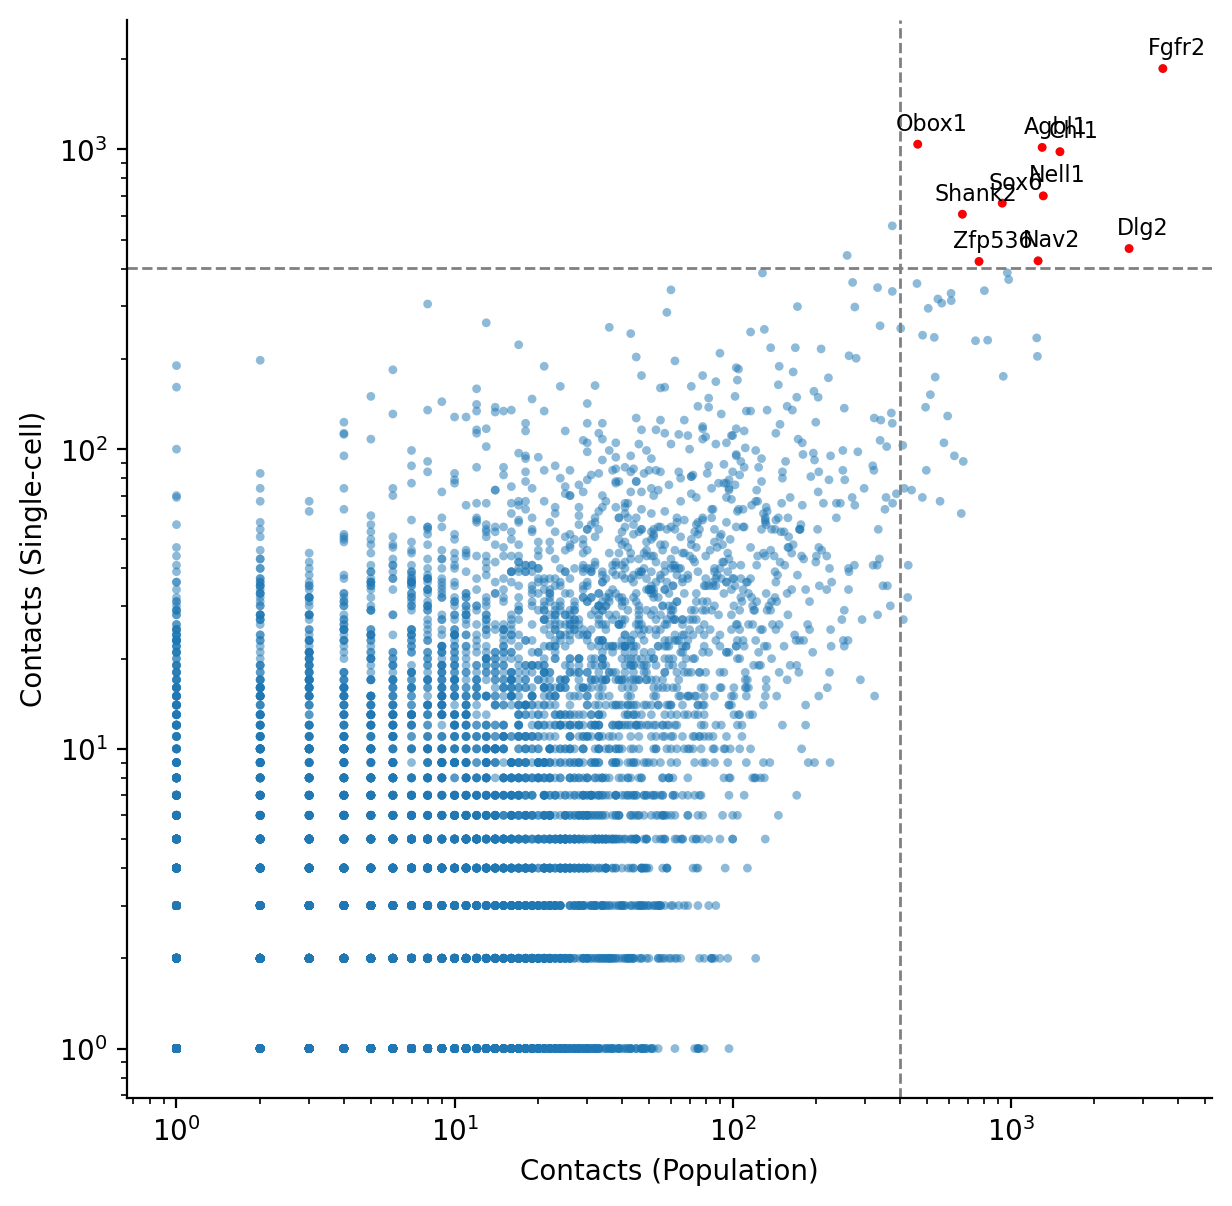

,gene_name,contact_count_pop,rank_pop,contact_count_sc,rank_sc
0,Fgfr2,3524,1.0,1862,1.0
1,Dlg2,2664,2.0,467,9.0
2,Chl1,1503,3.0,983,4.0
3,Nell1,1309,4.0,700,5.0
4,Agbl1,1297,5.0,1016,3.0
5,Nav2,1254,6.0,425,11.0
11,Sox6,932,12.0,662,6.0
14,Zfp536,769,15.0,423,12.0
17,Shank2,670,18.0,608,7.0
35,Obox1,463,36.0,1041,2.0


In [40]:
# Plotting the scatter plot with log scales and annotations
q = 0.995
threshold = np.quantile(df['contact_count_pop'], q)
print(f"At quantile {q}, count threshold is ~{int(threshold)}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7

sns.scatterplot(
    data=df, 
    x='contact_count_pop', 
    y='contact_count_sc',
    ec='none',
    alpha=0.5,
    s=10,
)

# Adding lines to indicate thresholds
plt.axvline(threshold, color='gray', lw=1, linestyle='--')
plt.axhline(threshold, color='gray', lw=1, linestyle='--')

# Identifying and coloring points beyond the threshold
df_filtered = df[(df['contact_count_pop'] > threshold) & (df['contact_count_sc'] > threshold)]

sns.scatterplot(
    data=df_filtered, 
    x='contact_count_pop', 
    y='contact_count_sc', 
    color='red',
    ec='none',
    s=10,
)

# Annotating the red points
for i, row in df_filtered.iterrows():
    plt.annotate(
        row['gene_name'], (row['contact_count_pop'], row['contact_count_sc']), 
        textcoords='offset points', xytext=(5, 5), ha='center', fontsize=8,
    )

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Contacts (Population)')
plt.ylabel('Contacts (Single-cell)')
sns.despine()
plt.show()

df_filtered

In [41]:
database = 'ontology'
query_genes = df_filtered['gene_name'].to_list()
print(query_genes)
edf = gget.enrichr(query_genes, database=database)
print(edf.columns)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head()

Fri Dec 20 12:13:34 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


['Fgfr2', 'Dlg2', 'Chl1', 'Nell1', 'Agbl1', 'Nav2', 'Sox6', 'Zfp536', 'Shank2', 'Obox1']
Index(['rank', 'path_name', 'p_val', 'z_score', 'combined_score',
       'overlapping_genes', 'adj_p_val', 'database'],
      dtype='object')


,path_name,adj_p_val,overlapping_genes
0,regulation of osteoblast proliferation (GO:003...,0.004158,"[NELL1, FGFR2]"
1,nervous system development (GO:0007399),0.004158,"[NELL1, NAV2, SOX6, SHANK2]"
2,regulation of osteoblast differentiation (GO:0...,0.026476,"[NELL1, FGFR2]"
3,protein side chain deglutamylation (GO:0035610),0.026476,[AGBL1]
4,regulation of morphogenesis of a branching str...,0.026476,[FGFR2]


In [42]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Look for specific genes

In [ ]:
query_gene = 'Sox2'

a_query = adata[:, adata.var['genes'].str.contains(query_gene)].copy()
a_query = a_query[a_query.X.sum(axis=1) > 1, :].copy()

b_query = bdata[:, bdata.var['genes'].str.contains(query_gene)].copy()
b_query = b_query[b_query.X.sum(axis=1) > 1, :].copy()

print(a_query)
print()
print(b_query)

In [ ]:
a_query.var['genes']

In [ ]:
adata.var['genes'].to_list()[:5]

In [ ]:
def plot_polygons(gene_list):
  """
  Plots a simple polygon for each element in the given list, 
  with each gene annotating a vertex.

  Args:
    gene_list: A list of strings, where each string contains 
               semicolon-separated gene names.
  """

  for i, genes in enumerate(gene_list):
    gene_names = genes.split(';')
    num_genes = len(gene_names)

    # Generate coordinates for the vertices
    angles = np.linspace(0, 2*np.pi, num_genes, endpoint=False)
    x = np.cos(angles)
    y = np.sin(angles)

    # Create the plot
    plt.figure()
    plt.fill(
        x, y, 
        linewidth=2, 
        alpha=1,
        c='deepskyblue', 
        edgecolor='k',
    )

    # Annotate the vertices with gene names, placing them outside
    for j, gene in enumerate(gene_names):
      angle_rad = angles[j]
      # Calculate annotation position outside the polygon
      text_x = 1.2 * np.cos(angle_rad)  # Adjust 1.2 for distance from the vertex
      text_y = 1.2 * np.sin(angle_rad)
      plt.plot(
          x[j], y[j], 
          markersize=10,
          marker="o",
          c='deepskyblue',
          markeredgecolor='k',
          markeredgewidth=1.75,
      )
        
      plt.annotate(
          gene, (x[j], y[j]),
          textcoords="offset points", 
          xytext=(text_x*25, text_y*12),
          ha='center', va="center"
      ) 

    plt.axis('equal')
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    sns.despine(left=True, bottom=True)
    plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sample_genes = locus.var['genes'].sample(5).to_list()
plot_polygons(sample_genes)
sample_genes

In [ ]:
# plot 
locus.var['genes'].values

In [ ]:
break

In [ ]:
# a_locus = adata[locus_list, :].copy()
# a_locus = a_locus[:, a_locus.X.sum(axis=0) > 1]
# a_locus

In [ ]:
# H_a = a_locus.to_df()

# node_params = {
#     's' : 1,
#     'ec' : 'k',
#     'lw' : 1,
#     'marker' : ".",
#     'zorder' : 2,
# }

# line_params = {
#     'lw' : 0.1,
#     'alpha' : 0.5,
#     'zorder' : 1,
# }

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 8, 5

# pdf = ut.sort_by_lowest_index(H_a)

# plt2.plot_incidence(
#     pdf, 
#     node_color='k',
#     node_params=node_params,
#     line_params=line_params,
# )

# plt.title(f"Chromosome 2")

In [ ]:
break

In [ ]:
# print(genes)

In [ ]:
obs = adata.obs.copy()

in_list = obs[obs.index.isin(locus_list)]
out_list = obs[~obs.index.isin(locus_list)]

print(f"{'In List Shape:':<20} {in_list.shape}")
print(f"{'Out List Shape:':<20} {out_list.shape}")
print("-" * 30)

columns = [
    'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
    'CTCF', 'H3K27ac', 'H3K27me3', 
]

data = []
for column in columns:
    data.append([column, in_list[column].mean(), out_list[column].mean()])

df = pd.DataFrame(data, columns=['Column', 'In List Mean', 'Out List Mean'])
print(df.to_markdown(index=False, numalign="left", stralign="left"))

In [ ]:
in_list

In [ ]:
# edf = gget.enrichr(genes, database='ontolgy')
# edf

In [ ]:
print(f"{'Tfap2c' in genes=}")
print(f"{'Bmp7' in genes=}")
print(f"{'Cstf1' in genes=}")
print(f"{'Ctcfl' in genes=}")

In [ ]:

print(adata['chr2:174', :].obs['genes'].values[0].split(";"))

In [ ]:
bdata['chr2:95', :].obs.head()

In [ ]:
adata.obs['RNA_1'].median()

In [ ]:
a_hyperdges.head()

In [ ]:
break

In [ ]:
break